<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-signals" data-toc-modified-id="Load-signals-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load signals</a></span></li><li><span><a href="#Compute-the-TNR-and-PR-of-stationary-signal" data-toc-modified-id="Compute-the-TNR-and-PR-of-stationary-signal-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Compute the TNR and PR of stationary signal</a></span></li><li><span><a href="#Compute-TNR-and-PR-of-time-varying-signal" data-toc-modified-id="Compute-TNR-and-PR-of-time-varying-signal-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Compute TNR and PR of time varying signal</a></span></li><li><span><a href="#Compute-TNR-and-PR-from-spectrum" data-toc-modified-id="Compute-TNR-and-PR-from-spectrum-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Compute TNR and PR from spectrum</a></span></li></ul></div>


# How to compute tone-to-noise and prominence ratios according to ECMA method

This tutorial explains how to use MOSQITO to compute the TNR and PR, indicating the proeminence of tonal components in a signal. For more information on the implementation of the metric, you can refer to the [documentation](../docs/tone-to-noise-prominence_ratio.md)

The following commands are used to import the necessary functions.

In [1]:
# Add MOSQITO to the Python path
import sys
sys.path.append('..')

# Import numpy
import numpy as np
# Import plot function
import matplotlib.pyplot as plt
# Import multiple spectrum computation tool
from scipy.signal import stft
# Import mosqito functions
from mosqito.utils import load
from mosqito.sound_level_meter import noct_spectrum
from mosqito.sq_metrics import pr_ecma_st, pr_ecma_tv, pr_ecma_freq
from mosqito.sq_metrics import tnr_ecma_st, tnr_ecma_tv, tnr_ecma_freq

# Import MOSQITO color sheme [Optional]
from mosqito import COLORS

# To get inline plots (specific to Jupyter notebook)
%matplotlib notebook

## Load signals
In this tutorial, the signals are imported from .wav files. The tutorial [Audio signal basic operations](./tuto_signal_basic_operations.ipynb) gives more information about the syntax of the import and the other supported file types. You can use any .wav file to perform the tutorial or you can download the [time varying signal](../tests/input/white_noise_442_1768_Hz_varying.wav) and the [sationary signal](../tests/input/white_noise_442_1768_Hz_stationary.wav) from MOSQITO that are used in the following.

In [2]:
# Define path to the .wav file
# To be replaced by your own path
path_st = "../tests/input/white_noise_442_1768_Hz_stationary.wav"
# load signal
sig_st, fs_st = load(path_st, wav_calib=0.01)
# plot signal
t_st = np.linspace(0, (len(sig_st) - 1) / fs_st, len(sig_st))
plt.figure(1)
plt.plot(t_st, sig_st, color=COLORS[0])
plt.xlabel('Time [s]')
plt.ylabel('Acoustic pressure [Pa]')
plt.title('Stationary signal')

[Info] Signal resampled to 48 kHz to allow calculation.


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Stationary signal')

[Info] Signal resampled to 48 kHz to allow calculation.


<IPython.core.display.Javascript object>


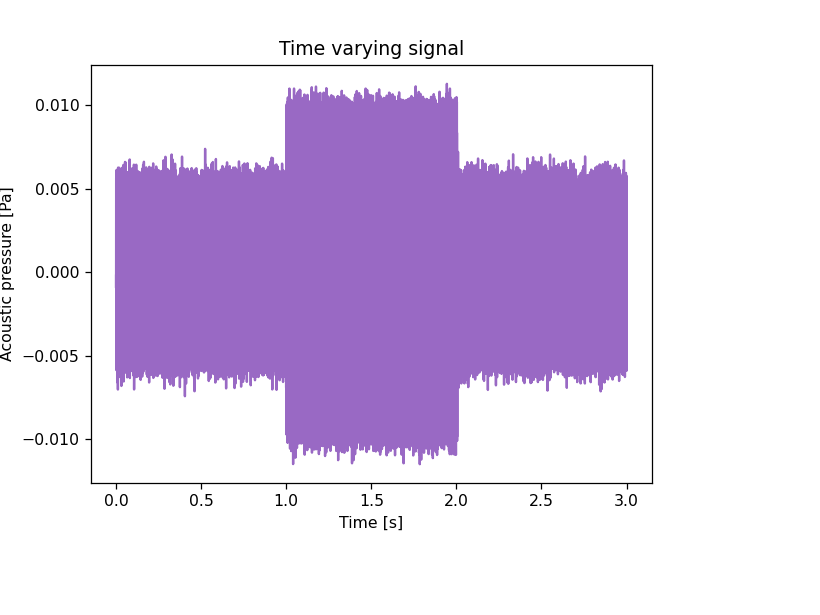

Text(0.5, 1.0, 'Time varying signal')

In [3]:
# Define path to the .wav file
# To be replaced by your own path
path_tv = "../tests/input/white_noise_442_1768_Hz_varying.wav"
# load signal
sig_tv, fs_tv = load(path_tv, wav_calib=0.01)
# plot signal
t_tv = np.linspace(0, (len(sig_tv) - 1) / fs_tv, len(sig_tv))
plt.figure(2)
plt.plot(t_tv, sig_tv, color=COLORS[1])
plt.xlabel('Time [s]')
plt.ylabel('Acoustic pressure [Pa]')
plt.title('Time varying signal')

## Compute the TNR and PR of stationary signal
The test signal consists in 2 tones at 442Hz and 1768Hz added to a white noise at 80 dB. The commands below are used to plot its 24th octave band spectrum.

In [4]:
# Compute spectrum
plt.figure(3)
spectrum, freqs = noct_spectrum(sig_st, fs_st, fmin=24, fmax=12600, n=24)
plt.semilogx(freqs, 20*np.log10(spectrum/2e-5), color=COLORS[0])
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude [dB re. 2e-5Pa]")

<IPython.core.display.Javascript object>

Text(0, 0.5, 'Amplitude [dB re. 2e-5Pa]')

The spectrum obviously shows a high-level tonal component.

To study this tonal component, the functions "tone_to_noise_ecma" and "prominence_ratio_ecma" are then used with 4 parameters:

- The signal type (stationary / non-stationary),
- The signal values,
- The sampling frequency,
- The prominence criteria (if True the algorithm only returns the prominent values according to ECMA 74)

The commands below shows how to compute the TNR and PR of a steady signal by using the functions from MOSQITO. The scripts computes the ratios in dB and returns both the total and individual values (with specification of the tonal frequency). There is no need to enter the frequency of the potential tonal components, the algorithm automatically detects them according to Sottek method.

In [5]:
# Tone-to-noise Ratio calculation
t_tnr, tnr, prom, tones_freqs = tnr_ecma_st(sig_st, fs_st, prominence=True)
# Prominence Ratio calculation
t_pr, pr, prom, tones_freq = pr_ecma_st(sig_st, fs_st, prominence=True)


# print the results
print("Tone-to-noise ratio: " , tnr , " dB at ", tones_freqs, " Hz")
print("T-TNR: ", t_tnr," dB")
print("Prominence ratio: " , pr , " dB at ", tones_freq, " Hz")
print("T-PR:", t_pr,"dB")

Tone-to-noise ratio:  [31.40178392 26.8806489 ]  dB at  [ 442. 1768.]  Hz
T-TNR:  [32.71505359]  dB
Prominence ratio:  [30.72207589 26.83739332]  dB at  [ 442. 1768.]  Hz
T-PR: [32.21062984] dB


The results can also be plotted, with the prominence limit to indicate either the tones are proeminent or not.

In [6]:
# Prominence criteria
freqs = np.arange(90,11200,100)
limit = np.zeros((len(freqs)))
for i in range(len(freqs)):
    if freqs[i] >= 89.1 and freqs[i] < 1000:
        limit[i] = 8 + 8.33 * np.log10(1000/freqs[i])
    if freqs[i] >= 1000 and freqs[i] < 11200:
        limit[i] = 8 

# Plot
plt.figure(figsize=(10,6))
plt.plot(freqs, limit, color='#e69f00', linewidth=2,dashes=[6,2],label='Prominence criteria')
plt.bar(tones_freqs, tnr,width=10, color='#69c3c5')  
plt.legend(fontsize=16)                      
plt.grid(axis='y')
plt.ylabel("TNR [dB]")
            

plt.title("Discrete tones TNR values \n  (Total TNR = "+str(np.around(t_tnr, decimals=1))+" dB)", fontsize=16)
plt.legend()

# Frequency axis
plt.xlabel("Frequency [Hz]")
plt.xscale('log')
xticks_pos = [100,1000,10000] + list(tones_freqs)
xticks_pos = np.sort(xticks_pos)
xticks_label = [str(elem) for elem in xticks_pos]
plt.xticks(xticks_pos, labels=xticks_label, rotation = 30)   

<IPython.core.display.Javascript object>

([<matplotlib.axis.XTick at 0x2071d8daf40>,
 [Text(100.0, 0, '100.0'),
  Text(442.0, 0, '442.0'),
  Text(1000.0, 0, '1000.0'),
  Text(1768.0, 0, '1768.0'),
  Text(10000.0, 0, '10000.0')])

## Compute TNR and PR of time varying signal
The commands below shows how to compute the TNR and PR of a time varying signal using the functions from MOSQITO. Only the TNR results are plotted, but the PR plots can be obtained by the exact same way just by replacing "tnr" by "pr".

d:\scripts\github_svn\mosqito_martin\mosqito\sq_metrics\tonality\tone_to_noise_ecma\_spectrum_smoothing.py:79: RuntimeWarning: invalid value encountered in true_divide
  smoothed_spectrum[:,i] = 10 * np.log10(spec_sum / len(bin_index[(bin_index<stop[j]) & (bin_index>(stop[j]-m))]))
d:\scripts\github_svn\mosqito_martin\mosqito\sq_metrics\tonality\tone_to_noise_ecma\_screening_for_tones.py:176: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tones = np.asarray(tones)
d:\scripts\github_svn\mosqito_martin\mosqito\sq_metrics\tonality\tone_to_noise_ecma\_tnr_main_calc.py:250: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do th

<IPython.core.display.Javascript object>


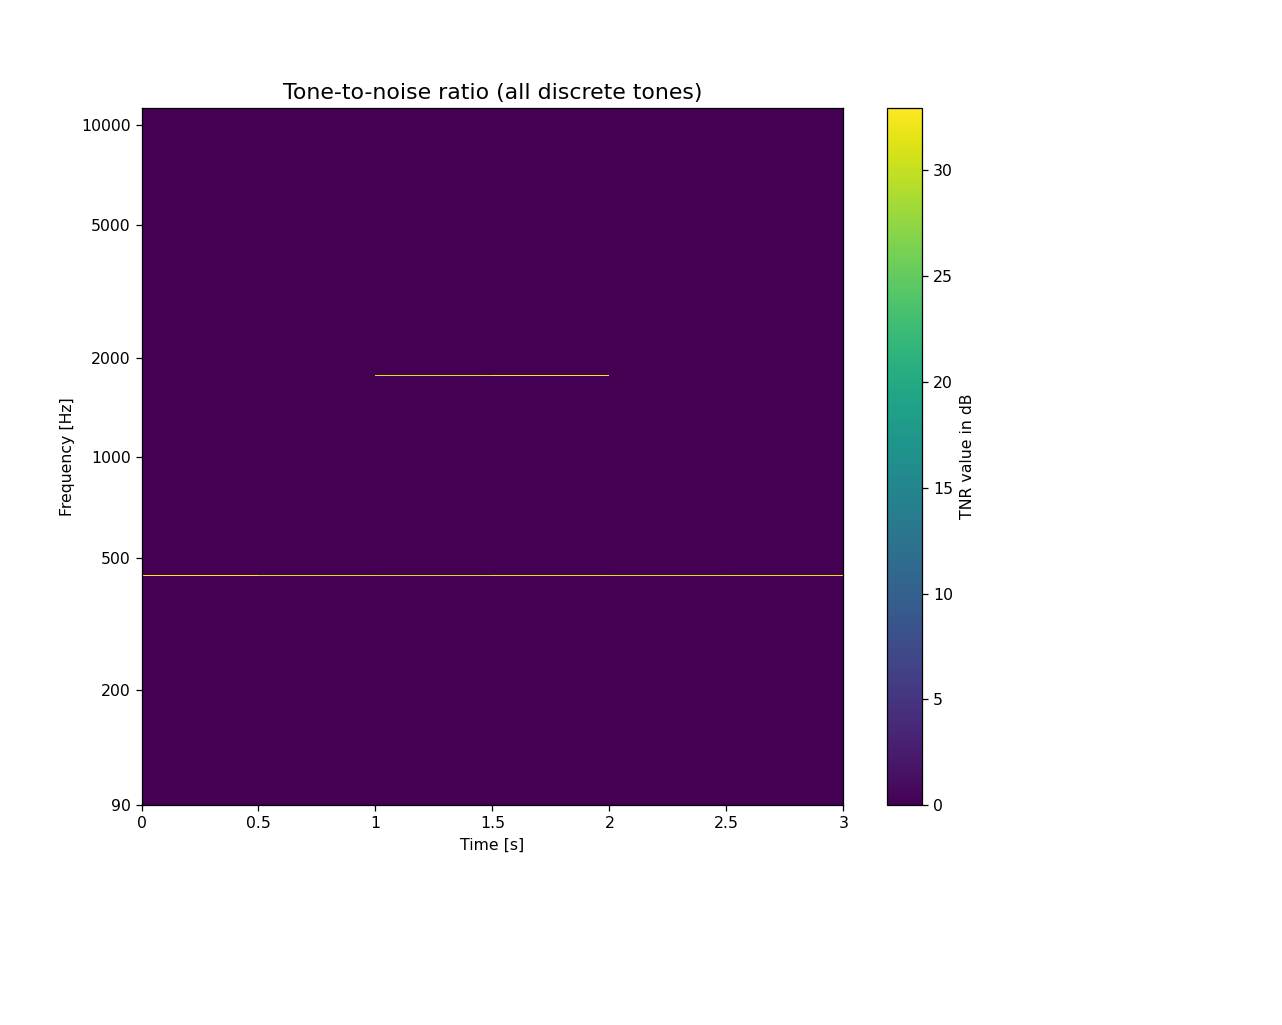

([<matplotlib.axis.XTick at 0x207208111c0>,
 [Text(0, 0, '0'),
  Text(1, 0, '0.5'),
  Text(2, 0, '1'),
  Text(3, 0, '1.5'),
  Text(4, 0, '2'),
  Text(5, 0, '2.5'),
  Text(6, 0, '3')])

In [7]:
# TNR calculation
t_tnr, tnr, promi, freqs, time = tnr_ecma_tv(sig_tv, fs_tv, prominence=False, overlap=0)

# PR calculation
t_pr, pr, promi, freqs, time = pr_ecma_tv(sig_tv, fs_tv, prominence=False, overlap=0)

# Plot
plt.figure(figsize=(10,8))
plt.pcolormesh(np.nan_to_num(tnr), vmin=0)
plt.colorbar(label = "TNR value in dB")
plt.title("Tone-to-noise ratio (all discrete tones)", fontsize=14)
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
freq_axis = np.logspace(np.log10(90),np.log10(11200),num=1000)
freq_labels = [90,200,500,1000,2000,5000,10000]
freq_ticks = []
for i in range(len(freq_labels)):
        freq_ticks.append(np.argmin(np.abs(freq_axis - freq_labels[i])))
plt.yticks(freq_ticks, labels=[str(elem) for elem in freq_labels])
nb_frame = np.floor(sig_tv.size / 0.5*fs_tv)
plt.xticks([0,1,2,3,4,5,6],labels=["0","0.5","1","1.5","2","2.5","3"])

## Compute TNR and PR from spectrum
The commands below shows how to compute the TNR and PR from a frequency spectrum using the functions from MOSQITO. 
The input spectrum can be either 1D with size (Nfrequency) or 2D with size (fNrequency x Ntime). The corresponding time axis can be either the same for all the spectra, with size (Nfrequency) or different for each spectrum with size (Nfrequency x Ntime).

In [10]:
# Compute multiple spectra along time
freqs, time, spectrum = stft(sig_tv, fs=fs_tv)

# TNR
t_tnr, tnr, promi, freqs, time = tnr_ecma_freq(spectrum, freqs, prominence=False)
# PR
t_pr, pr, promi, freqs, time = pr_ecma_freq(spectrum, freqs, prominence=False)

IndexError: index 2 is out of bounds for axis 1 with size 2

---

In [ ]:
from datetime import date
print("Tutorial generation date:", date.today().strftime("%B %d, %Y"))